In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import glob
import re

In [2]:
# Set up paths

path_to_data = '/expanse/nfs/cw3e/cwp140/'     # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
varname = 'SR' # 'PCPT' or 'UV' or 'SR'

if varname == 'SR':
    ## open SWE
    fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format('SNOW')
    SNOW = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')

    ## open PCPT
    fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format('PCPT')
    PCPT = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')
    PCPT = PCPT.resample(time="1D").mean('time') # resample WRF data to be m s-1

    ### calculate percentile for fraction of rain to snow
    ## SNOW is snow water equivalent kg m^2 = mm
    ## PCPT is total precipitation in mm day-1
    ## fraction of frozen precipitation or snow ratio (SR) = SWE/PCPT
    ds = xr.merge([SNOW, PCPT], compat="minimal")
    ds['SR'] = ds['SNOW'] / ds['PCPT']
    ds = ds.drop_vars(['SNOW', 'PCPT'])
    wrf = ds

else:

    fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format(varname)
    wrf = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')
    if temporal_res == '6hr':
        wrf = wrf.resample(time="6H").sum('time') # resample WRF data to be mm per day
    elif (temporal_res == 'daily') & (varname == 'PCPT'):
        wrf = wrf.resample(time="1D").sum('time') # resample WRF data to be mm per day
        
    elif (temporal_res == 'daily') & (varname == 'UV'):
        wrf = wrf.sel(lev='1000')
        wrf = wrf.resample(time="1D").mean('time') # resample WRF data to be m s-1
wrf

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


<xarray.Dataset>
Dimensions:  (time: 14610, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    SR       (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Tue Dec 11 12:06:10 AKST 2018

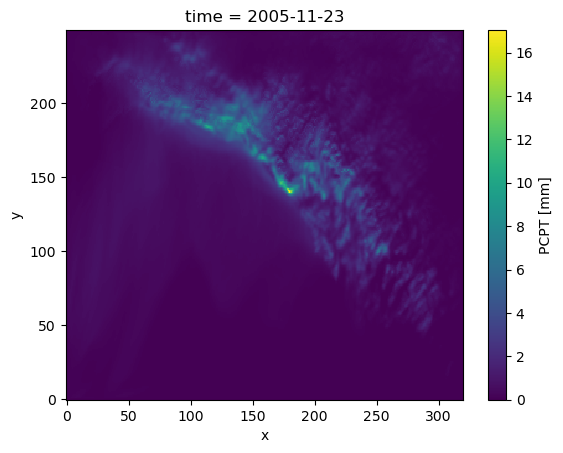

In [11]:
PCPT.sel(time='2005-11-23').PCPT.plot()

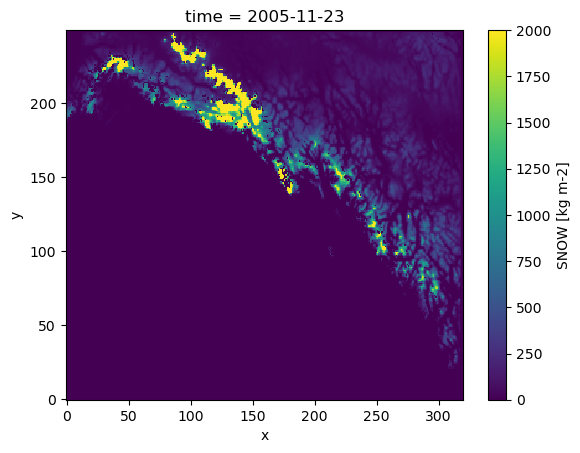

In [12]:
SNOW.sel(time='2005-11-23').SNOW.plot()

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


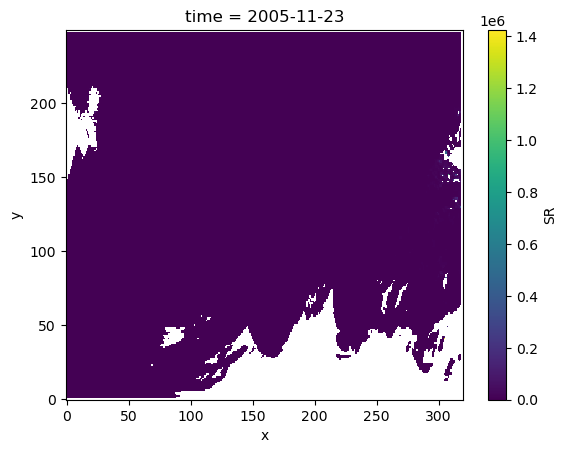

In [10]:
wrf.sel(time='2005-11-23').SR.plot()

In [5]:
%%time
## need to rechunk so time is a single chunk
wrf = wrf.chunk(dict(time=-1))

quantile_arr = np.array([0, .75, .95])

## Calculate the percentiles
quantile = wrf.quantile(quantile_arr, dim=['time'], skipna=True)

CPU times: user 479 ms, sys: 1.08 ms, total: 480 ms
Wall time: 480 ms


In [6]:
quantile

<xarray.Dataset>
Dimensions:   (y: 250, x: 320, quantile: 3)
Coordinates:
    lat       (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon       (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.75 0.95
Dimensions without coordinates: y, x
Data variables:
    SR        (quantile, y, x) float64 dask.array<chunksize=(3, 250, 320), meta=np.ndarray>

In [7]:
%%time
quantile = quantile.compute()

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


CPU times: user 1min 31s, sys: 47.9 s, total: 2min 19s
Wall time: 20min 41s


In [8]:
%%time
# write to netCDF
fname = os.path.join(path_to_data, 'preprocessed/SEAK-WRF-PCPT/{1}_quantiles_{0}.nc'.format(temporal_res, varname))
quantile.load().to_netcdf(path=fname, mode = 'w', format='NETCDF4')

CPU times: user 3.63 ms, sys: 3.25 ms, total: 6.89 ms
Wall time: 10.3 ms
